In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model.graph_utils import JunctionTree

from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
# from metal.label_model import LabelModel
# from metal.label_model.utils import (
#     compute_mu,
#     compute_covariance,
#     compute_inv_covariance,
#     print_matrix,
#     visualize_matrix
# )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


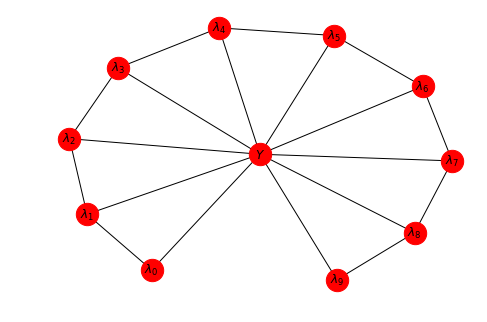

In [17]:
M = 10
N_CLUSTERS = 5
# deps_graph = ClusterDependencies(M, N_CLUSTERS)
deps_graph = ChainDependencies(M)
deps_graph.draw()

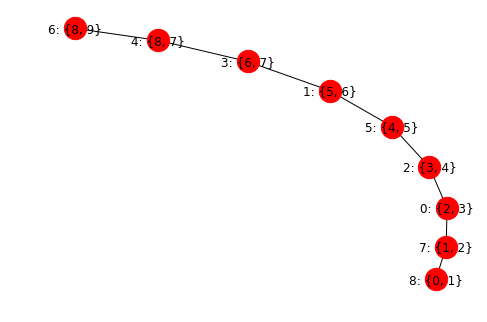

In [24]:
N = 1000 # Not used yet...
K = 2
data = DataGenerator(N, M, k=K, deps_graph=deps_graph)
data.jt.draw()

In [32]:
%%time

targets = {0:1, M:1}
p = data.P_marginal_brute_force(targets)
print(p)

0.10582402286053845
CPU times: user 4.08 s, sys: 5.17 ms, total: 4.09 s
Wall time: 4.09 s


In [33]:
%time data.P_marginal(targets)

CPU times: user 159 µs, sys: 12 µs, total: 171 µs
Wall time: 166 µs


0.11785159136124644

In [27]:
[data.P_marginal_brute_force({0:i}, condition_on={M:1}) for i in range(K+1)]

[0.2196863853316476, 0.19835414769453427, 0.5819594669738111]

In [22]:
[data.P_marginal({0:i}, condition_on={M:1}) for i in range(K+1)]

[0.2411477076036048, 0.4052529452206102, 0.353599347175785]